In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# "Maschinelles Lernen" - Supervised Learning

Der gegebene Datensatz enthält mehrere klinische Parameter und eine (Risiko-)Klassifikation. Das Ziel dieses Projektes ist es, eine möglichst gute Vorhersage für die (Risiko-)Klassifikation per ML-Modell zu erreichen.

## 1. Explorative Analyse der Daten

### Datensatz laden, einlesen und anschauen:

In [190]:
df_path = 'datasets/data.csv'

df = pd.read_csv(df_path)
df.head()

,Geschlecht,Alter,Raucher,Zigaretten_pro_Tag,Blutdrucksenker,Schlaganfall,Bluthochdruck,Diabetes,Gesamtcholesterin,Systole,Diastole,BMI,Puls,Blutglukosespiegel,Risikoklasse
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


### Dimensionen (die Anzahl der Zeilen und Spalten) des DataFrames zurückgeben.

In [191]:
df.shape

(4240, 15)

Der Datensatz enthält 4240 Zeilen und 15 Spalten.

### Variablen (Spalten) zur Verfügung.

In [192]:
df.columns

Index(['Geschlecht', ' Alter', ' Raucher', ' Zigaretten_pro_Tag',
       ' Blutdrucksenker', ' Schlaganfall', ' Bluthochdruck', ' Diabetes',
       ' Gesamtcholesterin', ' Systole', ' Diastole', ' BMI', ' Puls',
       ' Blutglukosespiegel', ' Risikoklasse'],
      dtype='object')

### Vorhersage für die (Risiko-) Klassifikation (__Risikoklasse__ ) aus den anderen klinischen Parameter

Als erster Schritt wurden die Zeilen mit NA-Wert aus dem Datensatz weggenommen, da unvollständige Daten zu Fehler bei der Vorhersage führen können.
Danach findet das Entfernen der Spalte __Risikoklasse__ aus unserem Pandas-Dataframe statt.
Der resultierende Datensatz enthält 489 Zeilen weniger.

In [193]:
df = df.dropna()

data = df.drop(columns=[' Risikoklasse'])
data.head()

# Die neue Dimensionen des Datensatzes geben
print(data.shape)

(3751, 14)


## 2. Dimensionreduktion des Datensatzes

### Principal Component Analysis (PCA)

Die ersten beiden Hauptkomponenten einer PCA einfach visualisieren, indem der Datensatz mit 14 Dimensionen auf 2D reduziert wird.

In [194]:
import plotly.express as px
from sklearn.decomposition import PCA

parameters = data[['Geschlecht', ' Alter', ' Raucher', ' Zigaretten_pro_Tag',
       ' Blutdrucksenker', ' Schlaganfall', ' Bluthochdruck', ' Diabetes',
       ' Gesamtcholesterin', ' Systole', ' Diastole', ' BMI', ' Puls',
       ' Blutglukosespiegel']]

pca = PCA(n_components=2)
components = pca.fit_transform(parameters)

fig = px.scatter(components, x=0, y=1, color=df[' Risikoklasse'], title='PCA Dimensionreduktion auf 2D bzgl. Risikoklasse').update_layout(
    xaxis_title='Principal Component 1', yaxis_title='Principal Component 2')
fig.show()

Die resultierenden Komponenten wurden grafisch in einem zweidimensionalen Diagramm dargestellt und als Achsen verwendet. Dabei wird die größte Varianz der Daten entlang der ersten Komponente und die zweitgrößte Varianz entlang der zweiten Komponente dargestellt.

Wie zu sehen ist, läßt sich aus dieser Visualisierung keine potenziell gute Separierbarkeit der Klassen ablesen.

## 3. Klassifikationsverfahren

### Klassifikationsvektor für das Supervised-Learning

In [195]:
classification = df[' Risikoklasse'].values
classification[0:10]

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [196]:
print(f'{sum(classification)} Fälle')
print(f'{len(classification) - sum(classification)} Kontrollen')

572 Fälle
3179 Kontrollen


### Aufteilen in Trainings- und Test-Set

__Scikit-Learn__ hat eine spezielle Funktion für diese Aufteilung, die wir benutzen werden, _train_test_split_:

In [197]:
from sklearn.model_selection import train_test_split

data_train, data_test, class_train, class_test = \
    train_test_split(parameters, classification, test_size=0.33, random_state=1, stratify=classification)

Die Parameter des Aufrufs:

* Die ersten beiden Parameter stellen die aufzuteilenden Daten dar. 
* _test\_size_ gibt hier an, dass 33 % der Daten in das Test-Set verschoben werden
* _random\_state_ stellt den _Seed_ für den Zufallszahlengenerator zur Verfügung und sorgt so für Reproduzierbarkeit
* _stratify = classification_ gibt an, dass die Verteilung der Klassen im Trainingsdatensatz der Verteilung im Datensatz _data_ entsprechen soll, d.h. genauso an ein großer Anteil an Erkrankten, wie auch an Nichterkrankten

### 3.1. k-Nearest-Neighbor Modell (kNN)

Das k-NN-Modell ist als _KNeighborsClassifier_ auch schon in __Scikit-Learn__ enthalten und wird benutzt.

In [198]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier()

#### Hypertuning des Parameters k im kNN-Modell

Der geeigneste Hyperparameter k des kNN-Modells wird im nächsten Abschnitt gesucht. Für ein performanteres Trainieren des Modells gibt es schon eine implementierte Methode in __Scikit-Learn__ _GridSearchCV_ , um eine Grid-Search-Suche auf dem Parameterraum durchzuführen. 

Wir beschränken den Suchraum auf den Bereich 1 bis 20:

In [199]:
from sklearn.model_selection import GridSearchCV
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

k_max = 20
param_grid = {'n_neighbors': np.arange(1, k_max + 1)} # Dictrionary mit allen Werten für den Parameter n_neighbors
knn_gscv = GridSearchCV(knn_classifier, param_grid, cv=5) # Gridsearch über dem Parameterraum
knn_gscv.fit(parameters, classification) # Fit des Modells auf den ganzen Datensatz

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])})

_fit_ ist allgemein die Funktion, die für das Training und Anpassen der Modelle benutzt wird.

Wenn wir uns die Fehlerkurve als (1.0 - mittlere Accuracy) angeben lassen, suchen wir das k mit dem geringsten Fehler bzw. der höchsten Accuracy: 

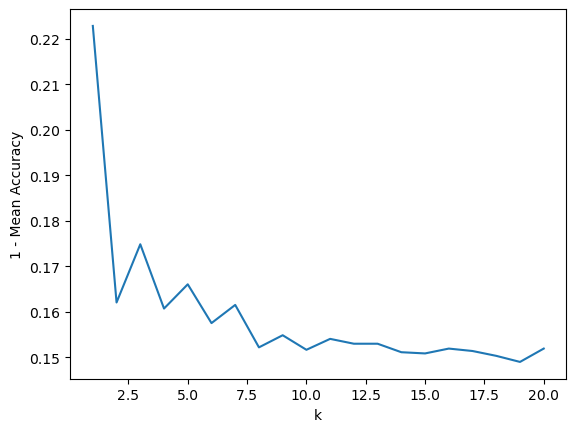

In [200]:
mean_scores = knn_gscv.cv_results_['mean_test_score']
plt.plot(np.arange(1, k_max + 1), 1.0 - mean_scores)
plt.xlabel('k')
plt.ylabel('1 - Mean Accuracy')
plt.show()

Nach dem Training kann man sich den besten Hyperparameter ausgeben lassen:

In [201]:
knn_gscv.best_params_

{'n_neighbors': 19}

D.h. 16 war der beste Parameter für k und der beste __kreuzvalidierte__ mittlere Score, der damit erreicht wurde war:

In [202]:
knn_gscv.best_score_

0.8509734576120728

D.h. wir schätzen aus unserem Datensatz für unser kNN-Modell ein optimales k von 19 (19 Nachbarn gehen in das Voting ein) und erreichen damit voraussichtlich eine Performance von $\sim$ 85.1 %  

### 3.2. Support Vector Machine (SVM)

In [203]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

svc_classifier = SVC(kernel='poly', probability=True)
svc_classifier.fit(data_train, class_train)

# Vorhersagen für Testdaten treffen
svc_predicted_data = svc_classifier.predict(data_test)

# Auswertung der Vorhersage
svc_accuracy = accuracy_score(class_test, svc_predicted_data)
print(f'Genauigkeit: {svc_accuracy}')

Genauigkeit: 0.8473344103392568


Die Parameter bei Initialisierung des SVM-Classifiers:
* _kernel_ ist ein Eingabeparameter für den SVC-Classifier.
* _probability_ gibt an, ob der SVM-Algorithmus eine Wahrscheinlichkeitsschätzung für die Vorhersage der Klassenetiketten geben soll.

Am obigen Beispiel wurde Polynom-Kernel-Funktion verwendet. Lineare- und RBF-Kernel wurden auch untersucht und die Eregebnisse ergeben:

* linear $\sim$ 84.73 %
* poly $\sim$ 84.73 %
* rbf $\sim$ 84.73 %

### 3.3. Logistiche Regression

In [204]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_classifier = LogisticRegression(solver='lbfgs', max_iter=1500)
lr_classifier.fit(data_train, class_train)

# Vorhersagen für Testdaten treffen
lr_predicted_data = lr_classifier.predict(data_test)

# Auswertung der Vorhersage
lr_accuracy = accuracy_score(class_test, lr_predicted_data)
print(f'Genauigkeit: {lr_accuracy}')

Genauigkeit: 0.8489499192245558


Klassifikationsverfharen Logistische Regression ergibt eine Genauigkeit von $\sim$ 84.89 %

### 3.4. Entscheidungsbäume

In [205]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=1, max_depth=1, min_samples_leaf=30)
dt_classifier.fit(data_train, class_train)

# Vorhersagen für Testdaten treffen
dt_predicted_data = dt_classifier.predict(data_test)

# Auswertung der Vorhersage
dt_accuracy = accuracy_score(class_test, dt_predicted_data)
print(f'Genauigkeit: {dt_accuracy}')

Genauigkeit: 0.8473344103392568


Klassifikationsverfharen Entscheidungsbäume ergibt eine Genauigkeit von $\sim$ 84.73 %

### 3.5. Ensemble von Entscheidungsbäumen (Random Forests)

In [206]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1)
rf_classifier.fit(data_train, class_train)

# Vorhersagen mit Testdaten
rf_predicted_data = rf_classifier.predict(data_test)

# Auswertung der Vorhersage
rf_accuracy = accuracy_score(class_test, dt_predicted_data)
print(f'Genauigkeit: {rf_accuracy}')

Genauigkeit: 0.8473344103392568


Klassifikationsverfharen Ensemble von Entscheidungsbäumen (Random Forests) ergibt eine Genauigkeit von $\sim$ 84.73 %

### 3.6. Ensemble von Neuronalen Netzen (Multilayer Perceptron):

In [207]:
from sklearn.neural_network import MLPClassifier

# Erstellen und Trainieren des MLP
mlp_classifier = MLPClassifier(hidden_layer_sizes=(10), max_iter=1000, random_state=1)
mlp_classifier.fit(data_train, class_train)

# Vorhersagen mit Testdaten
mlppredicted_data = mlp_classifier.predict(data_test)

# Auswertung der Vorhersage
mlp_accuracy = accuracy_score(class_test, mlppredicted_data)
print(f'Genauigkeit: {mlp_accuracy}')

Genauigkeit: 0.8416801292407108


Klassifikationsverfharen Ensemble von Neuronalen Netzen (Multilayer Perceptron) ergibt eine Genauigkeit von $\sim$ 84.17 %

### 3.7. Beurteilen die Ergebnisse unserer Klassifikationen

Die Ergebnisse aus den oben verschiedenen Klassifikationsverfahren sind im Prinzip sehr ähnlich. Im Folgenden werden diese aufgelistet:

## 4.  Abschätzung für die Bedeutung der einzelnen Feature bzgl. der Klassifikation

Als Erinnerung, die betrachtenden Parameter für die Vorhersage der Risikoklasse werden im Folgenden wieder dargestellt. Dies ist wichtig, da die nächsten Methoden die Ergebnisse in einem Array ausgeben, das den Indizes des Arrays des Parameters entspricht.

In [208]:
parameters = data[['Geschlecht', ' Alter', ' Raucher', ' Zigaretten_pro_Tag',
       ' Blutdrucksenker', ' Schlaganfall', ' Bluthochdruck', ' Diabetes',
       ' Gesamtcholesterin', ' Systole', ' Diastole', ' BMI', ' Puls',
       ' Blutglukosespiegel']]

### 4.1. Feature Importance from Random Forest

Diese Methode berechnet die Wichtigkeit jedes Merkmals in einem Random-Forest-Classifier. Das Attribut _feature_importances_ eines trainierten Random-Forest-Classifiers kann verwendet werden, um die Werte für die Wichtigkeit der Merkmale zu erhalten.

In [209]:
# Get the feature importance scores
feature_importances = rf_classifier.feature_importances_
print(feature_importances)

[0.02399604 0.13148572 0.01203833 0.05165149 0.00525792 0.00441923
 0.01950768 0.00776192 0.1236088  0.14041952 0.11868685 0.13592605
 0.09911646 0.12612399]


Die Parameter mit dem mit Abstand größten Einfluss im Vergleich zu den anderen sind:
* Systole: 0.1404
* Blutglukosespiegel: 0.1359
* Alter: 0.1315
* Blutglukosespiegel: 0.1261
* Diastole: 0.1187

### 4.2. Recursive Feature Elimination (RFE)

Bei dieser Methode werden rekursiv die am wenigsten wichtigen Merkmale eliminiert und die Modellperformance bei jedem Schritt evaluiert. Die Klasse RFE aus dem Modul sklearn._feature_selection_ kann zur Implementierung dieser Methode verwendet werden. Dies bezieht sich auf den Logistiche-Regression-Classifier.

In [210]:
from sklearn.feature_selection import RFE

# Perform RFE with cross-validation
rfe = RFE(estimator=lr_classifier, n_features_to_select=5, step=1)
rfe.fit(data_train, class_train)

# Print the selected features
print('Number of Features: %s' % (rfe.n_features_))
print('Selected Features: %s' % (rfe.support_))
print('Feature Ranking: %s' % (rfe.ranking_))

Number of Features: 5
Selected Features: [ True False False False  True  True  True  True False False False False
 False False]
Feature Ranking: [ 1  2  4  3  1  1  1  1  9  5  8  7 10  6]


Hierzu wurden drei Parameter gesucht, die die Risikoklasse am stärksten beeinflussen können. Diese ausgewählte Paremeter sind mit __True__ bzw. __1__ bezeichnet. Diese sind:
* Geschlecht
* Blutdrucksenker
* Schlaganfall
* Bluthochdruck
* Diabetes

### 4.3. Permutation Feature Importance

Bei dieser Methode werden die Werte der einzelnen Merkmale nach dem Zufallsprinzip vertauscht und die Auswirkungen auf die Modellleistung gemessen. Die Funktion _permutation_importance_ aus dem Modul sklearn.inspection kann zur Implementierung dieser Methode verwendet werden. Dieses Beispiel bezieht sich auf den Random-Forest-Classifier.

In [211]:
from sklearn.inspection import permutation_importance

# Compute feature importances using permutation importance
result = permutation_importance(rf_classifier, data_test, class_test, n_repeats=10, random_state=1)

# Print the feature importances
print('Feature Importances: ', result.importances_mean)

Feature Importances:  [ 4.03877221e-04 -9.69305331e-04  8.07754443e-05  2.10016155e-03
 -7.26978998e-04  8.07754443e-05 -1.05008078e-03  8.07754443e-05
 -2.42326333e-04 -4.36187399e-03 -1.13085622e-03 -6.46203554e-04
  4.84652666e-04 -1.13085622e-03]


Ein höherer Wert von _importances_mean_ für ein bestimmtes Merkmal zeigt an, dass die Leistung des Modells empfindlicher auf Änderungen dieses Merkmals reagiert und das Merkmal daher als wichtiger eingestuft wird. Die wichtigsten Parameter am Beispiel sind:
* Zigaretten_pro_Tag: 0.10456
* Puls: 0.088767
* Geschlecht: 0.07397
* Raucher / Schlaganfall / Diabetes: 0.054426

## 5. Klassifikationsverfahren auf einem veränderten Feature-Set

Da durch den Ansatz von PCA keine potenziell gute Separierbarkeit der Klassen abgelesen werden konnten, wird es versucht, die Dimension des Datensatzes mithilfe der Korrelationsmatrix zu reduzieren.

### Korrelationsmatrix

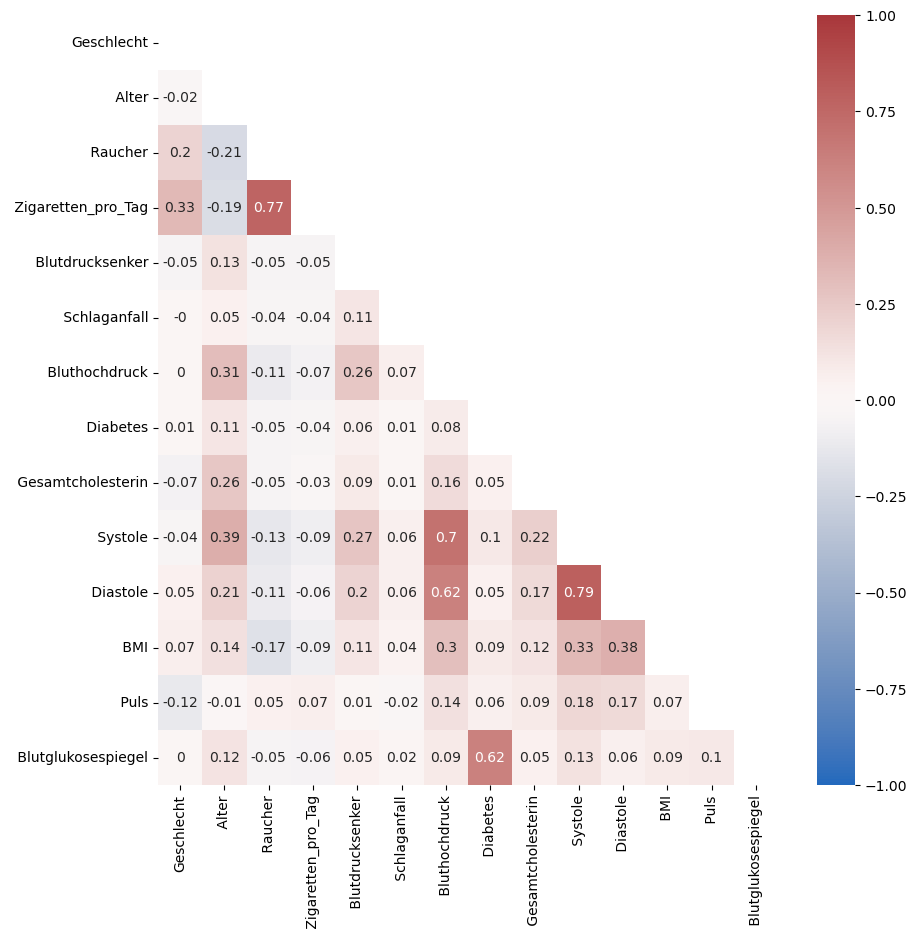

In [212]:
import seaborn as sns

matrix = data.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

Die Nummern in der Korrelationsmatrix geben den Wert des Korrelationskoeffizienten an. Ein Wert von 1 zeigt an, dass es eine perfekte positive Korrelation zwischen den beiden Variablen gibt, während ein Wert von -1 darauf hinweist, dass es eine perfekte negative Korrelation gibt. Ein Wert von 0 bedeutet, dass es keine Korrelation zwischen den Variablen gibt. Oben wurden die Korrelationen mit verschiedenen Farben dargestellt, um den Grad des Zusammenhangs zwischen den Variablen zu visualisieren. Eine starke positive Korrelation wird durch dunkle rot dargestellt, während eine starke negative Korrelation durch dunkle blau.

Die Koeffizienten, deren Betrag dem Wert 1 am nächsten liegt, werden für eine neue Dimensionierung des Datensatzes berücksichtigt. Die Parameter, die einen wesentlichen Einfluss auf die Risikoklasse haben, werden im Folgenden aufgeführt:
* Diastole - Systole: 0.79
* Zigaretten_pro_Tag - Raucher: 0.77
* Systole - Bluthochdruck: 0.7
* Diastole - Bluthochdruck: 0.62
* Blutglukosespiegel - Diabetes: 0.62

Mit solchen Parameter ergibt sich eine neue Dimension des Datensatzes, um eine möglichst gute Vorhersage für die (Risiko-)Klassifikation per ML-Modell zu erreichen. Die anderen klinischen Parameter scheinen keine großen Auswirkungen auf die gewünschten Ergebnisse zu haben, wenn sie verändert werden. Daraus folgt, dass die betrachtenden Parameter (veränderte Feature-Set) sind:

In [213]:
new_parameters_set = data[[' Raucher', ' Zigaretten_pro_Tag',
       ' Bluthochdruck', ' Diabetes',
       ' Systole', ' Diastole', ' Blutglukosespiegel']]

In [214]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

new_data_train, new_data_test, new_class_train, new_class_test = \
    train_test_split(new_parameters_set, classification, test_size=0.33, random_state=1, stratify=classification)

# Skalieren der Daten
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

data_train_scaled = robust_scaler.fit_transform(new_data_train)
data_test_scaled = robust_scaler.fit_transform(new_data_test)

mlp_classifier.fit(data_train_scaled, new_class_train)

# Vorhersagen mit skaliertenTestdaten
mlp_predicted_data_scaled = mlp_classifier.predict(data_test_scaled)

# Auswertung der Vorhersage
mlp_accuracy_scaled = accuracy_score(new_class_test, mlp_predicted_data_scaled)
print(f'Genauigkeit auf originalen Features: {mlp_accuracy}')
print(f'Genauigkeit auf skalierten Features: {mlp_accuracy_scaled}')

Genauigkeit auf originalen Features: 0.8416801292407108
Genauigkeit auf skalierten Features: 0.8489499192245558


### Explain what are the different Scalers.

Am Beispiel wurde das Klassifikationsverfharen Ensemble von Neuronalen Netzen (Multilayer Perceptron) verwendet und durch _RobustScaler_ tranformiert. Dieses war das Einzige von den oben vorgestellten Klassifikationsverfharen, deren Leistung durch eine Analyse der Korrelationsmatrix bzw. eine Dimensionreduktion der Features etwas verbessert wurde:
* mit originalen Features $\sim$ 84.17 %
* mit veränderten (bedeutenderen) Features $\sim$ 84.89 %

Bei den anderen Klassifikationsverfharen wurde die Leistung entweder gleich geblieben oder verslechtert. Aus diesem Grund, kann man zusammenfassen. dass:
* die Daten profitieren nicht immer von der Skalierung. Nicht alle Datensätze erfordern eine Skalierung der Merkmale, und einige Datensätze können sogar schlechter abschneiden, wenn sie skaliert werden
* die Skalierungsmethode können sich nicht eignen
* das Modell reagiert möglicherweise nicht auf die Skalierung von Merkmalen. Entscheidungsbäume und Random-Forest waren beispielweise unempfindlich gegenüber der Skalierung.
* es ist besser, mit verschiedenen Vorverarbeitungsansätze zu experimentieren und ihre Leistung zu vergleichen, um den besten Ansatz für den Datensatz und Modell zu finden.
